## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import libraries

In [1]:
import os
import cv2
import glob
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks_cwt


## 1. Camera calibration using chessboard images

In [2]:
def camera_calibration(image_tmpl, output_dir='.'):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    h, w = 6, 9
    obj_pt = np.zeros((h*w, 3), np.float32)
    obj_pt[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    obj_pts = [] # 3d points in real world space
    img_pts = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(image_tmpl)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        if ret == True:
            obj_pts.append(obj_pt)
            img_pts.append(corners)

    # Do camera calibration given object points and image points
    img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(obj_pts, img_pts, img_size, None, None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    output_file = os.path.join(output_dir, 'dist_pickle.p')
    pickle.dump(dist_pickle, open(output_file, 'wb'))
    return (mtx, dist)
    
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

## 2. Undistort raw image

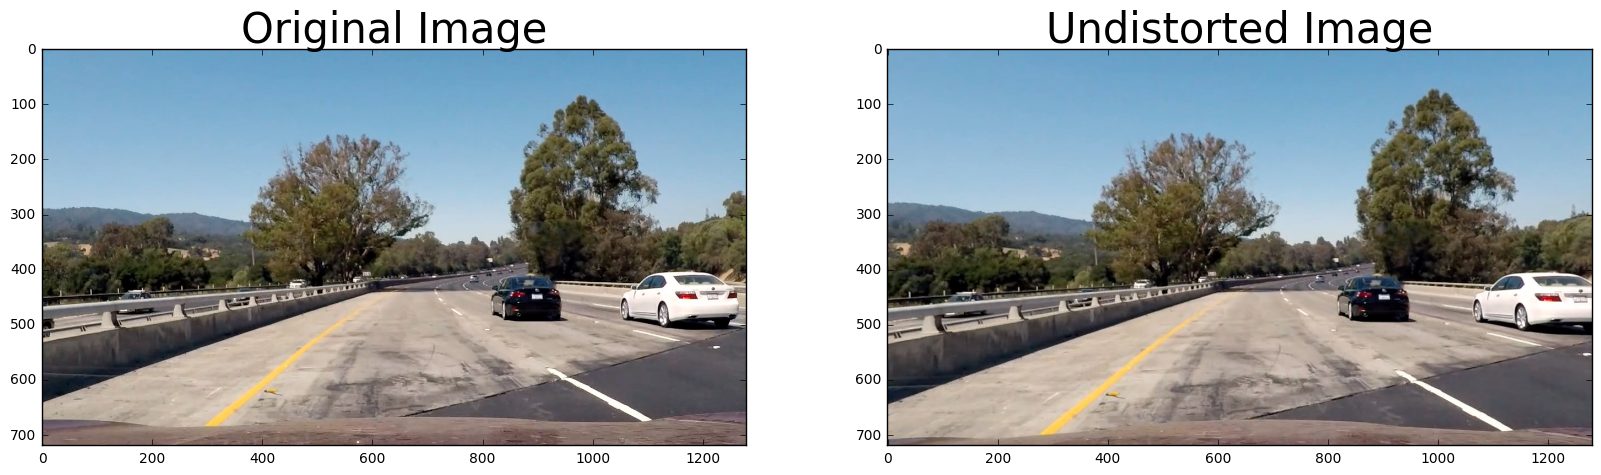

In [2]:
def load_undistort_params(input_dir='.'):
    input_file = os.path.join(input_dir, 'dist_pickle.p')
    dist_pickle = pickle.load(open(input_file, 'rb'))
    return (dist_pickle['mtx'], dist_pickle['dist'])

def undistort_image(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# Test undistortion on an image
img = cv2.imread('test_images/test7.jpg')
mtx, dist = load_undistort_params()
dst = undistort_image(img, mtx, dist)
cv2.imwrite('test_images/test7_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Perspective transform

True

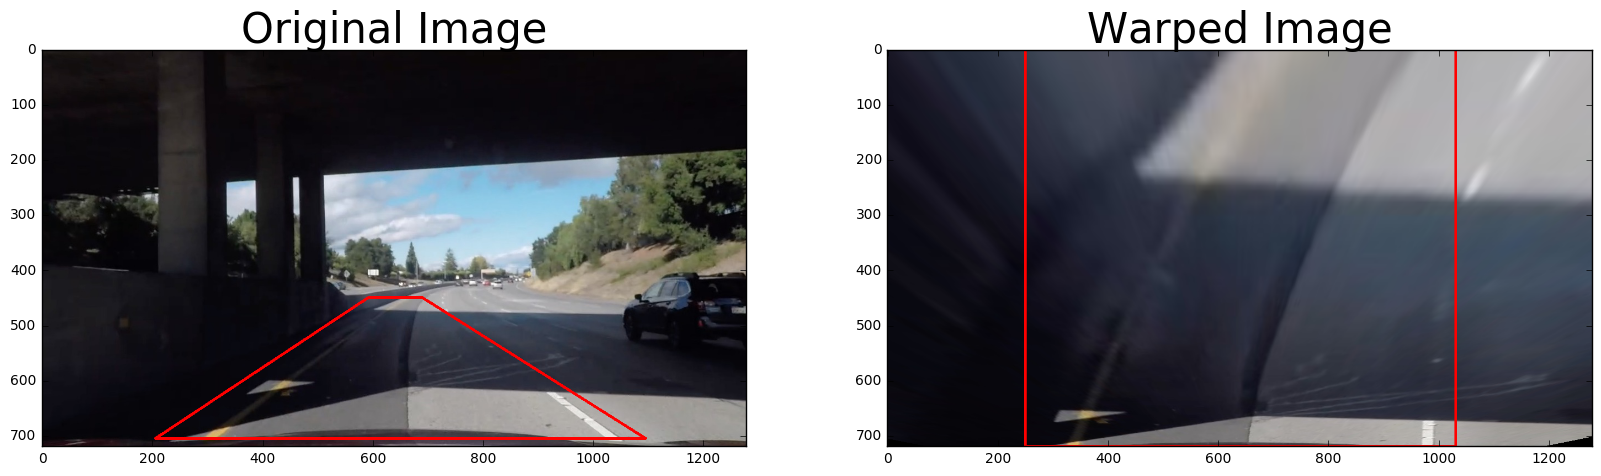

In [115]:
def perspective_transform(image, inverse=False):
    """
    Try not to see too far away where can't be identify clearly
    after transform.
    """
    src = np.float32([(592, 450), (689, 450), (205, 706), (1095, 706)])
    dst = np.float32([(250, -200), (1030, -200), (250, 720), (1030, 720)])
    
    if inverse:
        src, dst = dst, src
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, None, flags=cv2.INTER_LINEAR)
    
    return warped, M

dst = cv2.imread('test_images/challenge7_undist.jpg')
warped, M = perspective_transform(dst)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
pts = np.array([(592, 450), (689, 450), (1095, 706), (205, 706)])
dst_line = dst.copy()
cv2.polylines(dst_line, [pts], True, (0, 0, 255), thickness=3)
ax1.imshow(cv2.cvtColor(dst_line, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)

pts = np.array([(250, 0), (1030, 0), (1030, 720), (250, 720)])
warped_line = warped.copy()
cv2.polylines(warped_line, [pts], True, (0, 0, 255), thickness=3)
ax2.imshow(cv2.cvtColor(warped_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=30)
cv2.imwrite('test_images/warped.jpg', cv2.cvtColor(warped_line, cv2.COLOR_BGR2RGB))

## 4. Create Threshold Binary Image (Color & Graident)

### Histogram Equalization

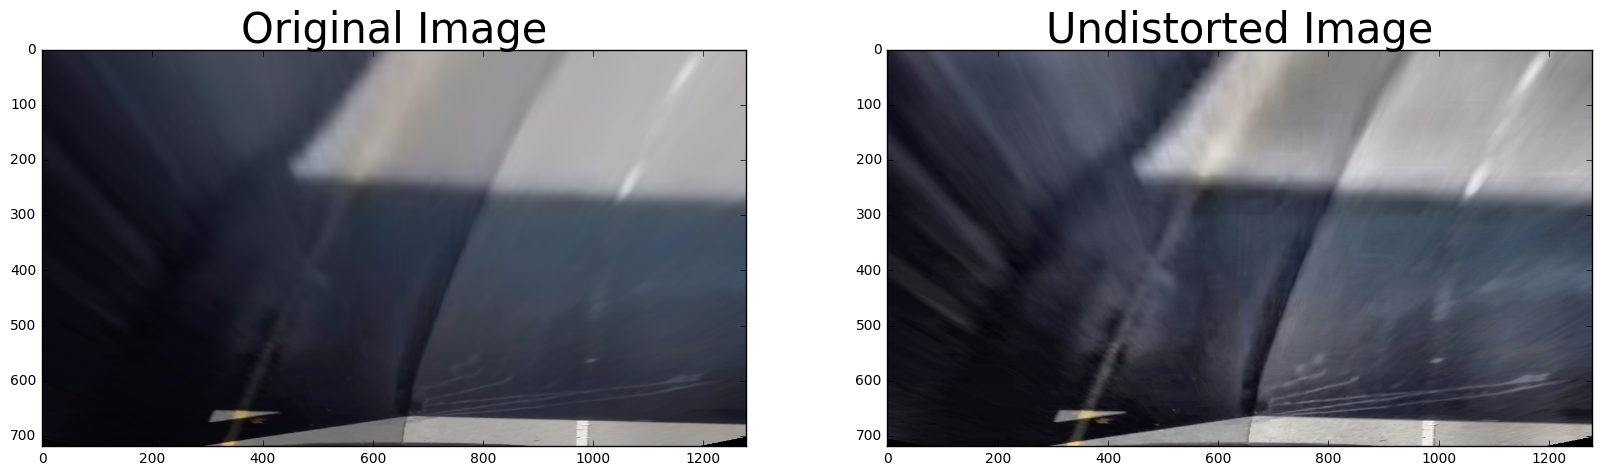

In [116]:
def histogram_equalization(image):
    """
    http://docs.opencv.org/3.2.0/d5/daf/tutorial_py_histogram_equalization.html
    """
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    yuv[:,:,0] = clahe.apply(yuv[:,:,0])
    image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    
    return image

equalized = histogram_equalization(warped)

# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

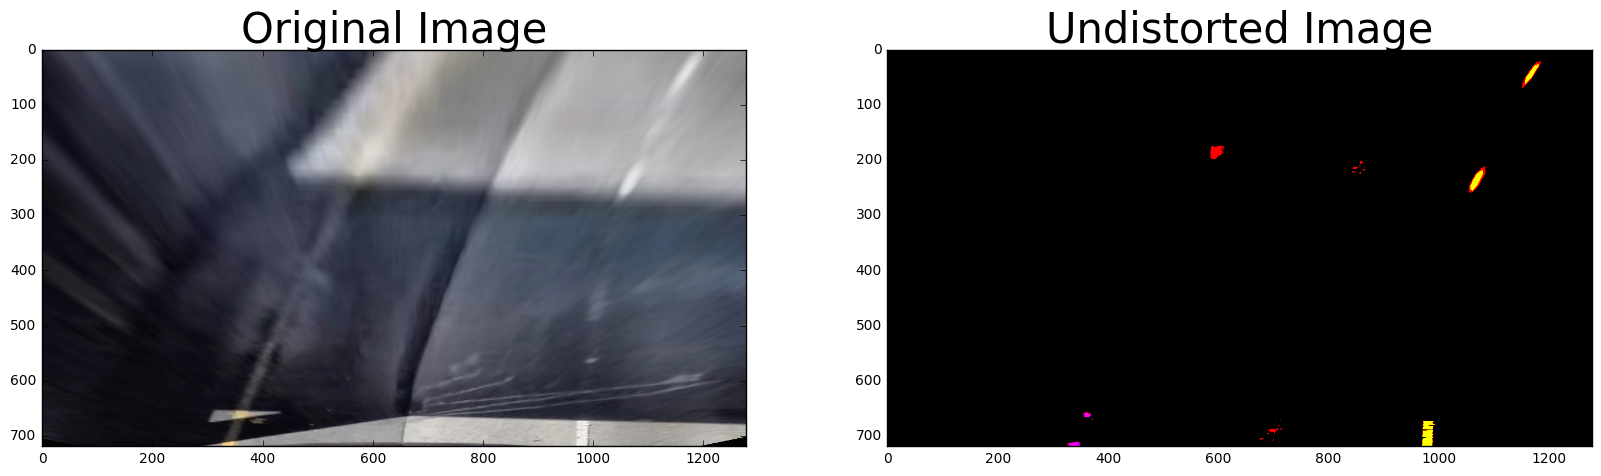

In [130]:
def create_threshold_binary_image(image, print_color=False):
    """
    Use different color space to threshold the image
    """
    image = np.copy(image)
    
    # HLS color space. S channel performs well
    # on filtering yellow and white
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    hls_min = np.array([  0,   0, 180])
    hls_max = np.array([255, 255, 255])
    hls_mask = cv2.inRange(hls, hls_min, hls_max)
    
    yellow_min  = np.array([ 10,  80, 100])
    yellow_max  = np.array([100, 210, 155])
    yellow_mask = cv2.inRange(hls, yellow_min, yellow_max)
        
    white_min  = np.array([  0, 215,   0])
    white_max  = np.array([255, 255, 255])
    white_mask = cv2.inRange(hls, white_min, white_max)
    hls_mask = yellow_mask + white_mask + hls_mask
    
    # CIELUV color space. L channel performs well
    # on filtering white color.
    luv = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    luv_min = np.array([225,   0,   0])
    luv_max = np.array([255, 255, 255])
    luv_mask = cv2.inRange(luv, luv_min, luv_max)
    
    # CIELAB color space. B channel performs well 
    # on filtering yellow color
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_min = np.array([  0,   0, 155])
    lab_max = np.array([255, 255, 200])
    lab_mask = cv2.inRange(lab, lab_min, lab_max)
    
    # sobel x (derivative in x axis) doesn't work well
    #l_sobelx = cv2.Sobel(hls[:,:,1], cv2.CV_64F, 1, 0)
    #l_abs_sobelx = np.abs(l_sobelx)
    #l_scaled_sobel = np.uint8(255*l_abs_sobelx/np.max(l_abs_sobelx))
    
    # threshold x gradient
    #sobel_min = np.array([20])
    #sobel_max = np.array([100])
    #l_sx_mask = cv2.inRange(l_scaled_sobel, sobel_min, sobel_max)
    
    if print_color:
        return np.dstack((hls_mask, luv_mask, lab_mask))

    binary = np.zeros_like(image[:,:,0])
    binary[yellow_mask.astype(bool) | \
           white_mask.astype(bool) | \
           hls_mask.astype(bool) | \
           luv_mask.astype(bool) | \
           lab_mask.astype(bool)] = 1    
    #binary = cv2.erode(binary, (5, 5), iterations=1)
    return binary
    
binary_img = create_threshold_binary_image(equalized, print_color=True)
    
# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

## 5. Find lane lines

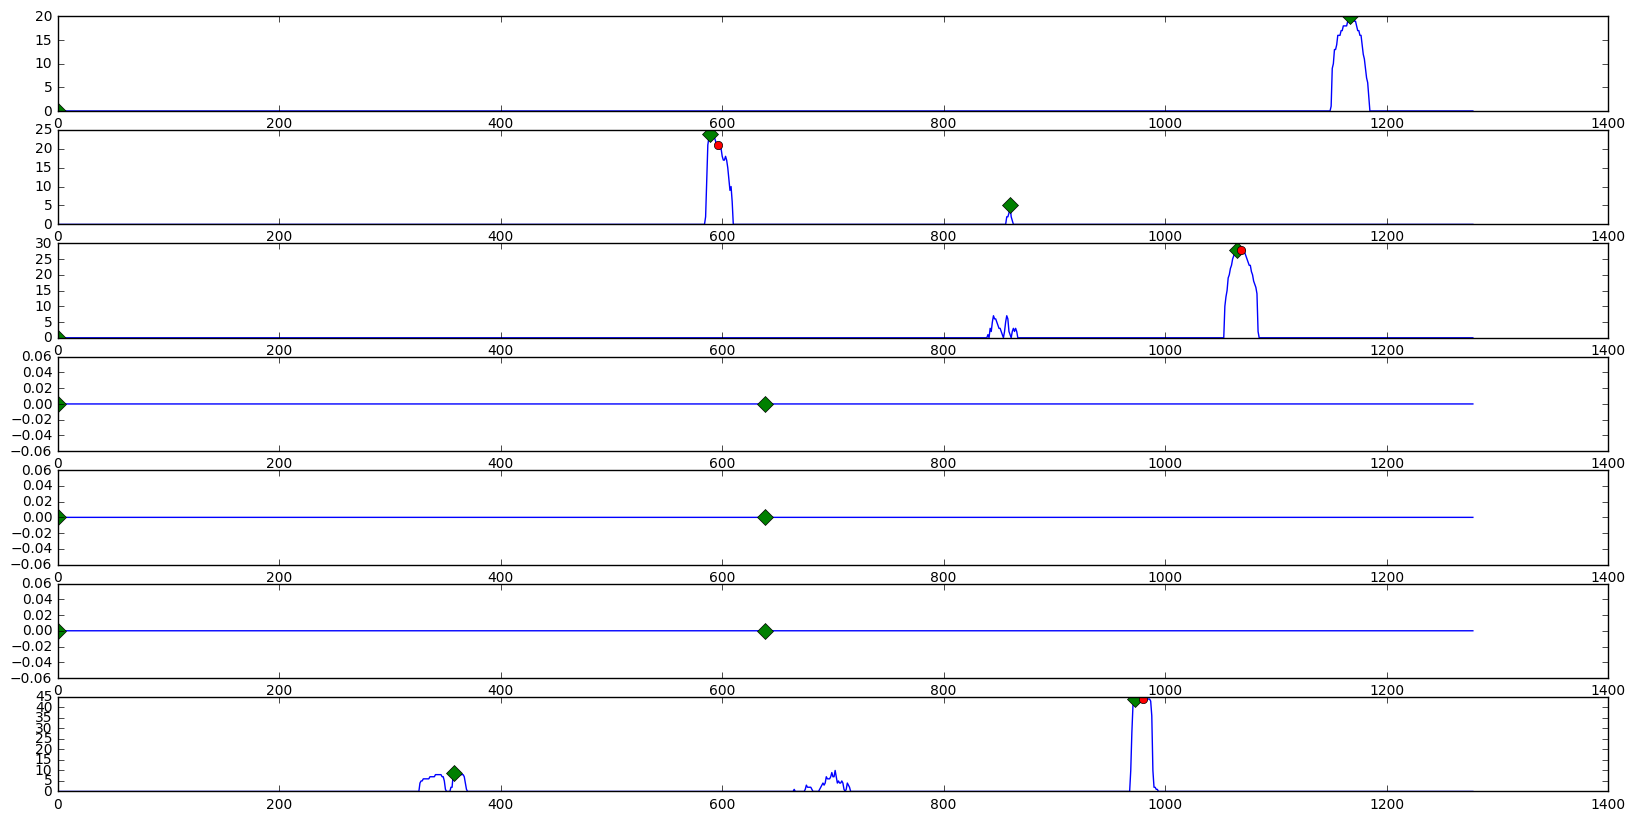

In [120]:
# Visiualize sliding window
# https://blog.ytotech.com/2015/11/01/findpeaks-in-python/

binary_img = create_threshold_binary_image(equalized)

nb_win = 7
width = binary_img.shape[1]
height = binary_img.shape[0]
win_size = math.ceil(height/nb_win)

f, axes = plt.subplots(nb_win, 1, figsize=(20,10))
for i, ax in enumerate(axes):
    start = i * win_size
    end = start + win_size
    
    histogram = np.sum(binary_img[start:end,:], axis=0)
    ax.plot(histogram)
    
    # argmax
    mid = width // 2
    l_peak = np.argmax(histogram[:mid])
    r_peak = np.argmax(histogram[mid:]) + mid
    ax.plot([l_peak, r_peak], histogram[[l_peak, r_peak]], 'D', color='g', ms=8)
    
    # peak
    indexes = find_peaks_cwt(histogram, np.arange(10, 100))
    indexes = [idx for idx in indexes if histogram[idx] > 20]
    ax.plot(indexes, histogram[indexes], 'o', color='red')
    

In [121]:
def find_lane_points(binary_image):
    """
    """
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    out_img = out_img.astype(np.uint8)

    green = (0, 255, 0)
    
    margin = 100
    minpix = 50
    
    l_margin = margin
    r_margin = margin
    
    width  = binary_image.shape[1]
    height = binary_image.shape[0]
    
    mid = width // 2
    histogram = np.sum(binary_image[height//2:,:], axis=0)
    l_base = np.argmax(histogram[:mid])
    r_base = np.argmax(histogram[mid:]) + mid

    nb_win = 8
    win_size = math.ceil(height/nb_win)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    l_inds = []
    r_inds = []
    
    l_curr = l_base
    r_curr = r_base
    
    for i in range(nb_win):
        idx = (nb_win - 1) - i

        h_min =   idx * win_size
        h_max = h_min + win_size
        
        l_min = l_curr - margin
        l_max = l_curr + margin
        r_min = r_curr - margin
        r_max = r_curr + margin
        
        cv2.rectangle(out_img, (l_min, h_min), (l_max, h_max), green, 2)
        cv2.rectangle(out_img, (r_min, h_min), (r_max, h_max), green ,2)

        l_fits = (
            (nonzeroy >= h_min) & 
            (nonzeroy <  h_max) & 
            (nonzerox >= l_min) & 
            (nonzerox <  l_max)).nonzero()[0]
        
        r_fits = (
            (nonzeroy >= h_min) & 
            (nonzeroy <  h_max) & 
            (nonzerox >= r_min) & 
            (nonzerox <  r_max)).nonzero()[0]
        
        l_inds.extend(l_fits)
        r_inds.extend(r_fits)
        
        if len(l_fits) > minpix:
            l_curr = np.int(np.mean(nonzerox[l_fits]))
        if len(r_fits) > minpix:
            r_curr = np.int(np.mean(nonzerox[r_fits]))
            
    lx = nonzerox[l_inds]
    ly = nonzeroy[l_inds]
    rx = nonzerox[r_inds]
    ry = nonzeroy[r_inds]
    
    out_img[nonzeroy[l_inds], nonzerox[l_inds]] = [255, 0, 0]
    out_img[nonzeroy[r_inds], nonzerox[r_inds]] = [0, 0, 255]

    return [lx, ly], [rx, ry], out_img

l_points, r_points, out_img = find_lane_points(binary_img)

In [122]:
def find_lane_points_with_prev(l_fit, r_fit, binary_image):

    margin = 100
    
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    l_inds = (
        (nonzerox > (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] - margin)) & 
        (nonzerox < (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] + margin))) 
    r_inds = (
        (nonzerox > (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] - margin)) & 
        (nonzerox < (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    lx = nonzerox[l_inds]
    ly = nonzeroy[l_inds] 
    rx = nonzerox[r_inds]
    ry = nonzeroy[r_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[l_inds], nonzerox[l_inds]] = [255, 0, 0]
    out_img[nonzeroy[r_inds], nonzerox[r_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    y_vals = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
    r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]
    
    l_window1 = np.array([np.transpose(np.vstack([l_x_fit-margin, y_vals]))])
    l_window2 = np.array([np.flipud(np.transpose(np.vstack([l_x_fit+margin, y_vals])))])
    l_pts = np.hstack((l_window1, l_window2))
    
    r_window1 = np.array([np.transpose(np.vstack([r_x_fit-margin, y_vals]))])
    r_window2 = np.array([np.flipud(np.transpose(np.vstack([r_x_fit+margin, y_vals])))])
    r_pts = np.hstack((r_window1, r_window2))
    
    cv2.fillPoly(window_img, np.int_([l_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([r_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return [lx, ly], [rx, ry], out_img


## 6. Measure Curvature

172.689013277 1053.64667433


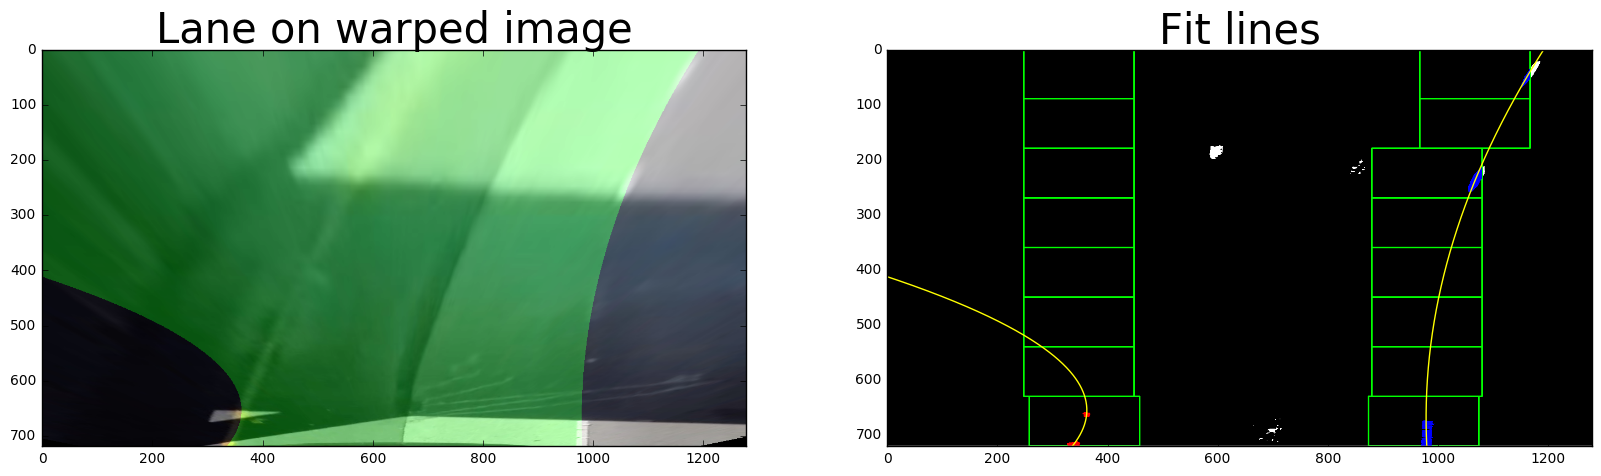

In [123]:
def fit_poly(x_vals, y_vals, y_max):
    # fit second order polynomial
    line_fit = np.polyfit(y_vals, x_vals, 2)
    
    # calculate radius of curvature
    curverad = ((1 + (2*line_fit[0]*y_max + line_fit[1])**2)**1.5) \
                             /np.absolute(2*line_fit[0])
    return line_fit, curverad

height = binary_img.shape[0]
l_fit, l_curverad = fit_poly(l_points[0], l_points[1], height)
r_fit, r_curverad = fit_poly(r_points[0], r_points[1], height)
print (l_curverad, r_curverad)

# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
y_vals = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
pts = np.hstack((pts_left, pts_right))

# visualize the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
result = cv2.addWeighted(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), 1, color_warp, 0.3, 0)
ax1.imshow(result)
ax1.set_title('Lane on warped image', fontsize=30)
# Draw found points
ax2.imshow(out_img)
ax2.plot(l_x_fit, y_vals, color='yellow')
ax2.plot(r_x_fit, y_vals, color='yellow')
ax2.set_xlim(0, 1280)
ax2.set_ylim(720, 0)
ax2.set_title('Fit lines', fontsize=30)

172.689013277 1039.43606894


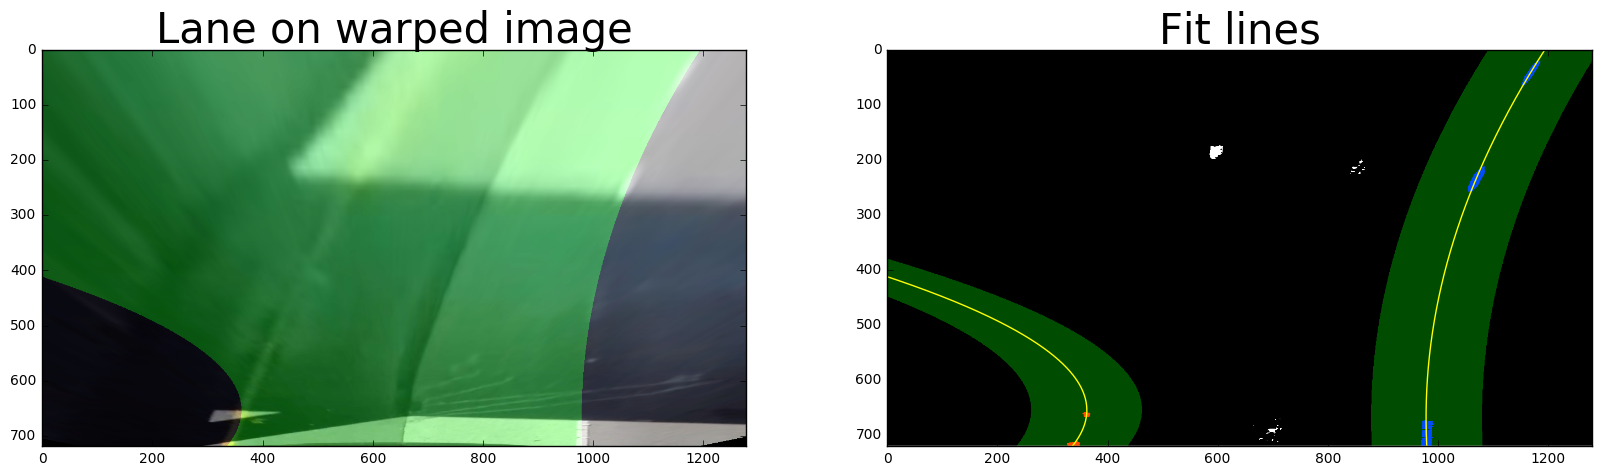

In [124]:
l_points, r_points, out_img = find_lane_points_with_prev(l_fit, r_fit, binary_img)


height = binary_img.shape[0]
l_fit, l_curverad = fit_poly(l_points[0], l_points[1], height)
r_fit, r_curverad = fit_poly(r_points[0], r_points[1], height)
print (l_curverad, r_curverad)

# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
y_vals = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
pts = np.hstack((pts_left, pts_right))

# visualize the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
result = cv2.addWeighted(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), 1, color_warp, 0.3, 0)
ax1.imshow(result)
ax1.set_title('Lane on warped image', fontsize=30)
# Draw found points
ax2.imshow(out_img)
ax2.plot(l_x_fit, y_vals, color='yellow')
ax2.plot(r_x_fit, y_vals, color='yellow')
ax2.set_xlim(0, 1280)
ax2.set_ylim(720, 0)
ax2.set_title('Fit lines', fontsize=30)

## 7 & 8. Reversed Perspective Transform

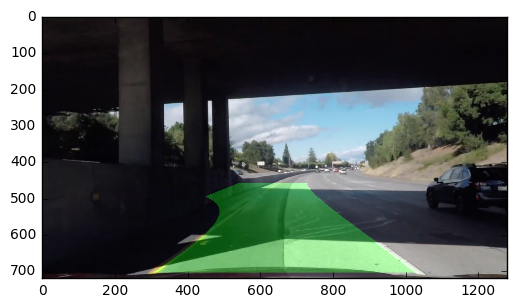

In [125]:
def create_lane_boundary_image(l_fit, r_fit, image):

    # Create an image to draw the lines on
    color_warp  = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    y_vals = np.linspace(0, 100, num=101)*(image.shape[1]/100)
    l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
    r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

    pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    return color_warp

boundary = create_lane_boundary_image(l_fit, r_fit, dst)
boundary, M = perspective_transform(boundary, inverse=True)

result = cv2.addWeighted(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB), 1, boundary, 0.3, 0)
plt.imshow(result)


## Video

In [95]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Line class

Define a class to receive the characteristics of each line detection

In [96]:
class Line():
    def __init__(self):  
        #: meters per pixel in y dimension
        self.ym_per_pix = 3/115 
        #: meters per pixel in x dimension
        self.xm_per_pix = 3.7/750 
        
        self.radius_of_curvature = 0.0
        self.fit = None
        self.detected = False
        
    @property
    def min_diff(self):
        return (5e-4, 5e-1, 1e2)
    
    def fit_poly(self, x_vals, y_vals, y_max):
        
        if not x_vals.any() or not y_vals.any():
            return 
        
        # fit second order polynomial
        self.fit = np.polyfit(y_vals, x_vals, 2)

        # calculate radius of curvature
        fit_m = np.polyfit(y_vals*self.ym_per_pix,
                           x_vals*self.xm_per_pix, 2)
        self.radius_of_curvature = \
            ((1 + (2*fit_m[0]*y_max*self.ym_per_pix + fit_m[1])**2)**1.5) / \
            np.absolute(2*fit_m[0])

    def validate(self, other):
        """
        check coefficient difference.
        """
        diff = np.abs(self.fit - other.fit)
        for d, m in zip(diff, self.min_diff):
            if d > m:
                #print('Coefficient difference: {}'.format(diff))
                return False
        return True
        
class Lane():
    
    def __init__(self, prev_lane=None):
        #: meters per pixel in y dimension
        self.ym_per_pix = 3./100 
        #: meters per pixel in x dimension
        self.xm_per_pix = 3.7/740 
        
        self.max_line_distance = 5.
        self.min_line_distance = 1.2
        self.distance = 0

        self.center = 0
        self.detected = False
        self.left_line = Line()
        self.right_line = Line()
        
        self.prev_lane = prev_lane
    
    def validate(self, prev_lane):
        
        result = True
        result = result and self.validate_lines()
        if prev_lane and prev_lane.detected:
            result = result and self.left_line.validate(prev_lane.left_line)
            result = result and self.right_line.validate(prev_lane.right_line)
        self.detected = result 
    
    def validate_lines(self):
        
        if self.left_line and self.left_line.fit is not None and \
            self.right_line and self.right_line.fit is not None:
            # check distance between left lane and right lane
            self.center = ((self.left_line.fit[2] + self.right_line.fit[2]) / 2 - 640) \
                          * self.xm_per_pix
            self.distance = np.abs(self.left_line.fit[2] - self.right_line.fit[2]) \
                            * self.xm_per_pix
            
            if self.distance > self.max_line_distance or \
               self.distance < self.min_line_distance:
                #print('Lines too close or too far. {}'.format(self.distance))
                return True
            return True
        
            # check curvature difference between left lane and right lane
            
        return False
        
    def create_lane_boundary_image(self, image):
        l_fit = self.left_line.fit 
        r_fit = self.right_line.fit
        
        # Create an image to draw the lines on
        color_warp  = np.zeros_like(image).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        y_vals = np.linspace(0, 100, num=101)*(image.shape[1]/100)
        l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
        r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

        pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        return color_warp   
    
    def draw_fit_lines(self, image):
        l_fit = self.left_line.fit 
        r_fit = self.right_line.fit
        
        y_vals = np.linspace(0, image.shape[0]-1, image.shape[0])
        
        if l_fit is not None:
            l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
            pts_left  = np.array(np.transpose(np.vstack([l_x_fit, y_vals])), np.int32).reshape(-1,1,2)
            cv2.polylines(image,  [pts_left], False, (255, 255, 0))
        
        if r_fit is not None:
            r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]
            pts_right = np.array(np.transpose(np.vstack([r_x_fit, y_vals])), np.int32).reshape(-1,1,2)
            cv2.polylines(image, [pts_right], False, (255, 255, 0))

In [147]:
MTX, DIST = load_undistort_params()

def process_frame(image):
    HISTORY_SIZE = 15
    
    image = image.copy()
    
    # lane detection pipeline
    undist    = undistort_image(image, MTX, DIST)
    warped, M = perspective_transform(undist)
    if np.average(warped) < 160 or np.average(warped) > 225:
        warped = histogram_equalization(warped)
    binary    = create_threshold_binary_image(warped)
    
    # find previous detected lane
    prev_lane = None
    for lane in process_frame.history[::-1]:
        if lane and lane.detected:
            prev_lane = lane
            break
  
    # extract lane lines
    if prev_lane and prev_lane.detected:
        #print("######### with prev")
        l_points, r_points, out_img = find_lane_points_with_prev(
            prev_lane.left_line.fit, prev_lane.right_line.fit, binary)
    else:
        #print("######### without prev")
        l_points, r_points, out_img = find_lane_points(binary)
        
    # default value
    boundary = np.zeros_like(undist)
    result = undist
    
    curr_lane = Lane()
    curr_lane.left_line.fit_poly(l_points[0], l_points[1], height)
    curr_lane.right_line.fit_poly(r_points[0], r_points[1], height)
    curr_lane.validate(prev_lane)

    if curr_lane.detected:
        boundary = curr_lane.create_lane_boundary_image(undist)
    elif prev_lane and prev_lane.detected:
        boundary = prev_lane.create_lane_boundary_image(undist)

        
    boundary, M = perspective_transform(boundary, inverse=True)
    result      = cv2.addWeighted(undist, 1, boundary, 0.3, 0)
        
    if len(process_frame.history) >= HISTORY_SIZE:
        process_frame.history.pop(0)
    process_frame.history.append(curr_lane)
  
    # build the result frame
    curr_lane.draw_fit_lines(out_img)
    new_h = image.shape[0]//2
    new_w = image.shape[1]//2
    output = np.zeros_like(image)
    
    undist = cv2.resize(undist, (0, 0), fx=.5, fy=.5)
    binary = cv2.resize(binary, (0, 0), fx=.5, fy=.5)
    out_img = cv2.resize(out_img, (0, 0), fx=.5, fy=.5)

    binary[binary > 0] = 255
    
    boundary = cv2.resize(boundary, (0, 0), fx=.5, fy=.5)
    result = cv2.resize(result, (0, 0), fx=.5, fy=.5)
    output[:new_h, :new_w] = undist
    output[new_h:, :new_w] = out_img
    output[:new_h, new_w:] = boundary
    output[new_h:, new_w:] = result
    
    # Print text
    cv2.putText(output, "Index: {}".format(process_frame.index),
                (50, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
    cv2.putText(output, "Left curvature: %.1f m." % curr_lane.left_line.radius_of_curvature, 
                (50, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
    cv2.putText(output, "Right curvature: %.1f m." % curr_lane.right_line.radius_of_curvature, 
                (50, 90), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
    cv2.putText(output, "Line distance: %.2f m." % curr_lane.distance,
                (50, 110), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
    
    if curr_lane.detected:
        cv2.circle(output, (60, 140), 5, (0, 255, 0), 10)
    else:
        cv2.circle(output, (60, 140), 5, (255, 0, 0), 10)
    
    process_frame.index += 1
    return output 

## Videos

In [143]:
process_frame.history = []
process_frame.index = 0

output = 'videos/project_video_output.mp4'
clip_in = VideoFileClip("videos/project_video.mp4")
clip_out = clip_in.fl_image(process_frame)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/project_video_output.mp4
[MoviePy] Writing video videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:33<00:00,  8.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_output.mp4 

CPU times: user 4min 45s, sys: 34.2 s, total: 5min 19s
Wall time: 2min 34s


In [142]:
process_frame.history = []
process_frame.index = 0

output = 'videos/challenge_video_output.mp4'
clip_in = VideoFileClip("videos/challenge_video.mp4")#.subclip(0, 5)
clip_out = clip_in.fl_image(process_frame)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/challenge_video_output.mp4
[MoviePy] Writing video videos/challenge_video_output.mp4


100%|██████████| 485/485 [00:55<00:00,  9.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/challenge_video_output.mp4 

CPU times: user 1min 47s, sys: 11.9 s, total: 1min 59s
Wall time: 55.5 s


In [148]:
process_frame.history = []
process_frame.index = 0

output = 'videos/harder_challenge_video_output.mp4'
clip_in = VideoFileClip("videos/harder_challenge_video.mp4")#.subclip(0,10)
clip_out = clip_in.fl_image(process_frame)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/harder_challenge_video_output.mp4
[MoviePy] Writing video videos/harder_challenge_video_output.mp4



100%|█████████▉| 1199/1200 [02:54<00:00,  7.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/harder_challenge_video_output.mp4 

CPU times: user 4min 49s, sys: 43.8 s, total: 5min 33s
Wall time: 2min 55s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))